In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
from matplotlib import cm
from matplotlib.colors import ListedColormap
import requests
import bs4
from bs4 import BeautifulSoup
plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#look at median income _std too
#look at quantile boundries

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_score
import xgboost as xgb
from joblib import dump, load

# EDA

To be able to see how the data is distributed and the relationships between various features I created a number of plots and graphs.

Firstly I wanted to see which variables were correlated with each other. To do this I used Pearson's R for the continuous variables and Cramer's V (a variation of Pearson's chi-squared statistic) to attempt to see the association between the categorical variables.

In [4]:
merged_df = pd.read_csv('merged_df_EDA.csv')

In [26]:
merged_df.emp_length = merged_df.emp_length.map(lambda x: 'unemployed'
                                                if x == ' ' else x)

In [27]:
merged_df.emp_length.unique()

array(['4 years', '1 year', '7 years', '10+ years', '8 years', '2 years',
       '3 years', '< 1 year', '9 years', '5 years', '6 years',
       'unemployed'], dtype=object)

In [5]:
number_columns = merged_df.select_dtypes(include='number')

overall_corrs = number_columns.corr().abs()
overall_corrs_unstacked = overall_corrs.unstack()
overall_corrs_unstacked = overall_corrs_unstacked.sort_values(kind='quicksort',
                                                              ascending=False)
overall_corrs_unstacked[overall_corrs_unstacked < 1][:30]

loan_amnt                 funded_amnt                 0.999998
funded_amnt               loan_amnt                   0.999998
out_prncp                 out_prncp_inv               0.999997
out_prncp_inv             out_prncp                   0.999997
total_pymnt               total_pymnt_inv             0.999996
total_pymnt_inv           total_pymnt                 0.999996
funded_amnt               funded_amnt_inv             0.999994
funded_amnt_inv           funded_amnt                 0.999994
                          loan_amnt                   0.999992
loan_amnt                 funded_amnt_inv             0.999992
open_acc                  num_sats                    0.998723
num_sats                  open_acc                    0.998723
annual_inc_joint          income_vs_average           0.991155
income_vs_average         annual_inc                  0.991155
annual_inc                income_vs_average           0.991155
income_vs_average         annual_inc_joint            0

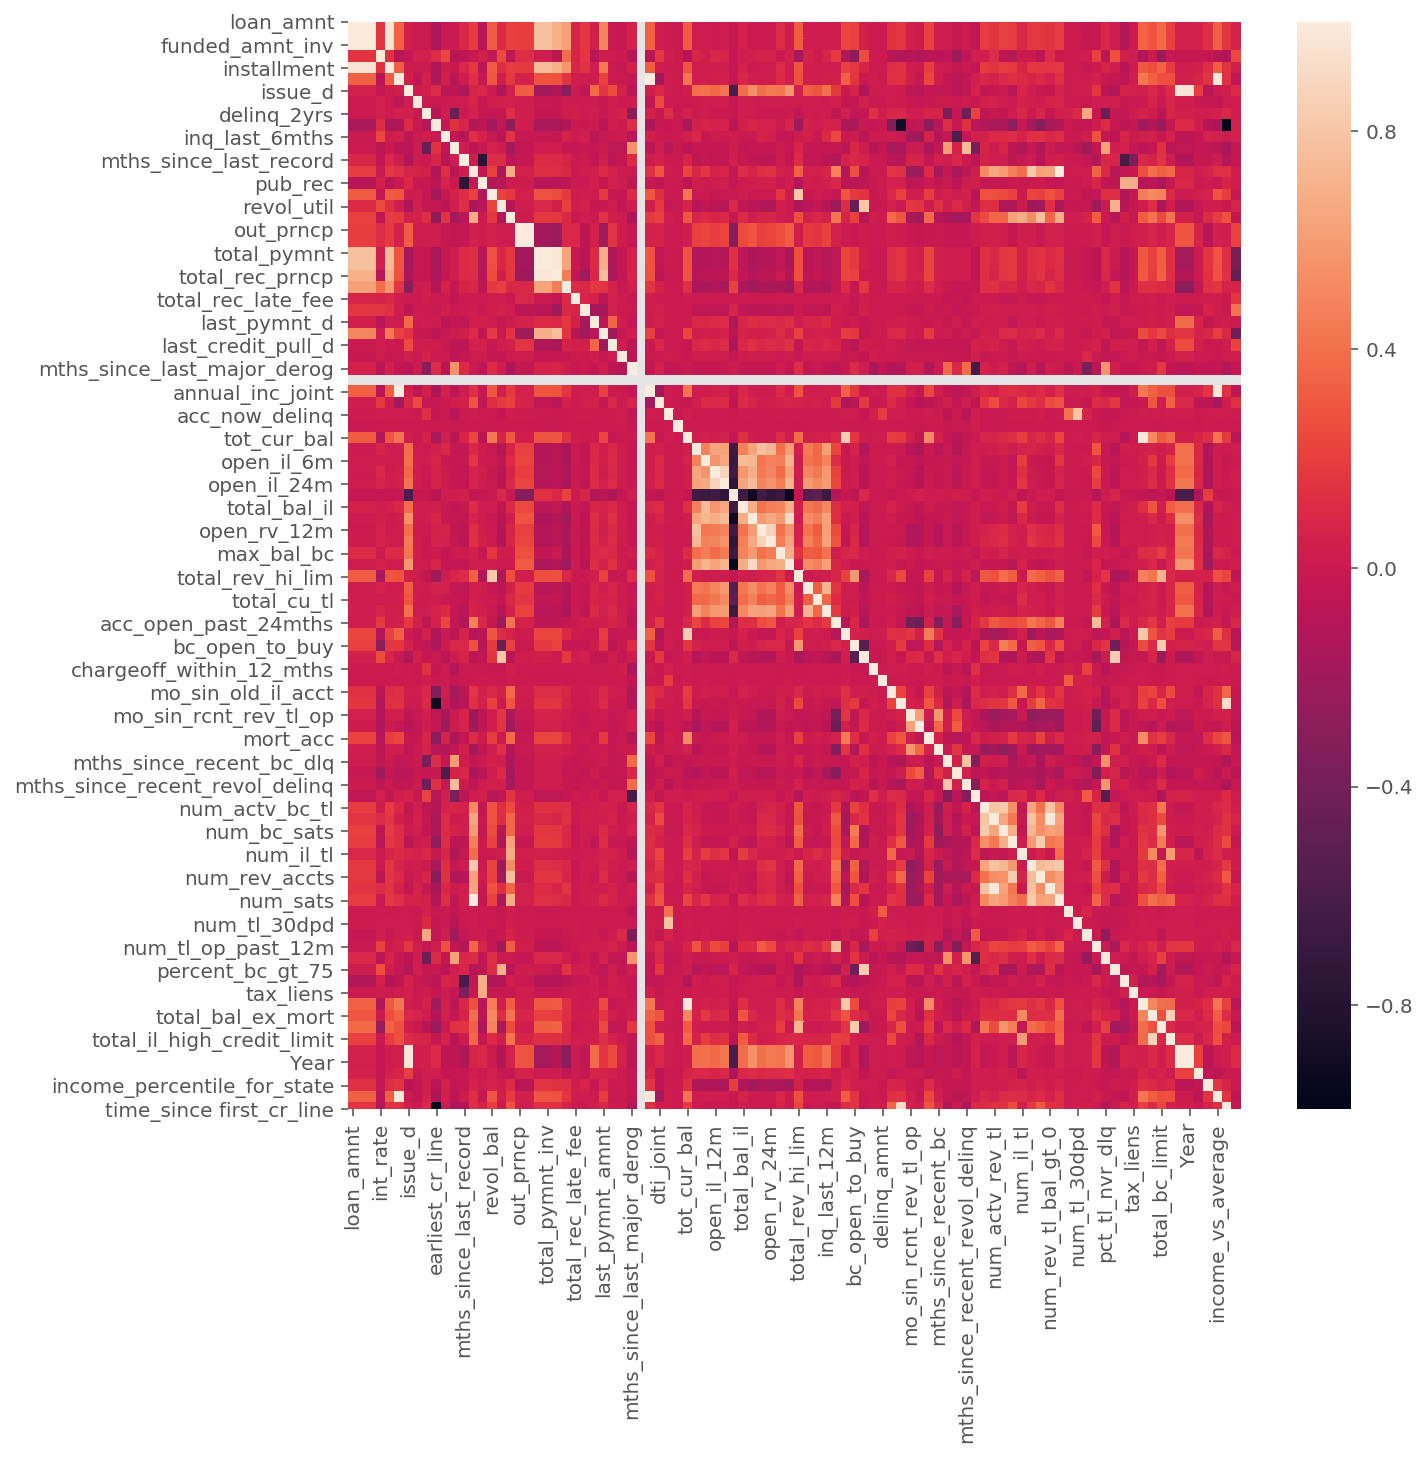

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(number_columns.corr())

In the above heatmap there are quite a few correlated areas, which would on the face of it suggest that we should use PCA to reduce the complexity of the model to ease the computational burden. However many of the correlated variables were dropped in the final model as they would have only been known once the loan had gone 'bad' (defaulted or been charged off). Additionally when trying to use PCA the performance of the models dropped significantly. However in the future I would want to look further into optimising my models with PCA in mind as this would greatly reduce computational costs.

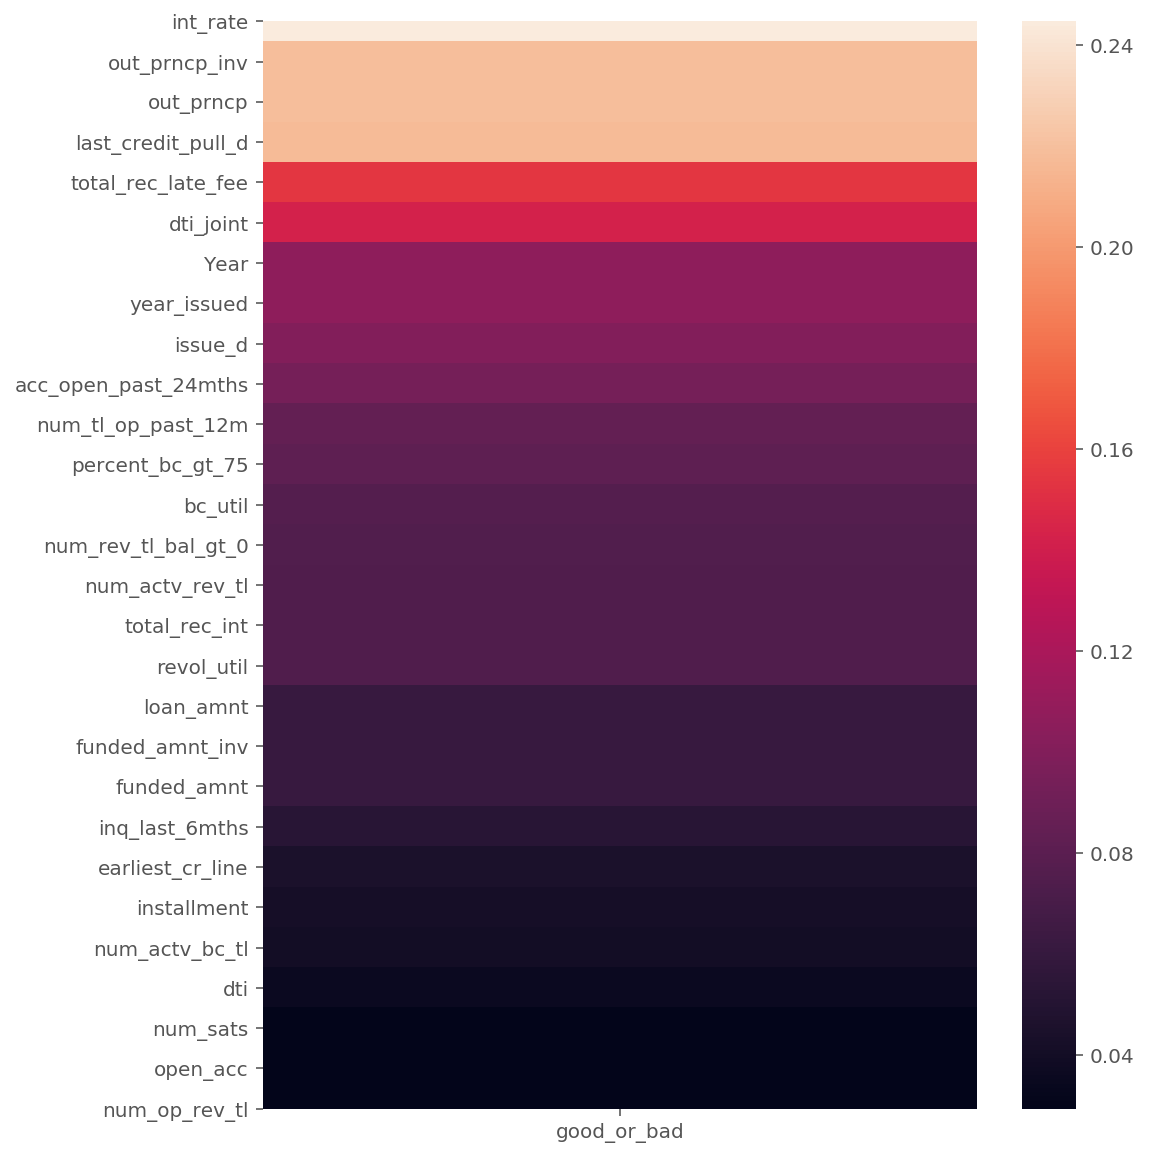

In [7]:
corr_with_loan_status = merged_df.corr()['good_or_bad'][:]
corr_with_loan_status.sort_values()
#things that positivly correlate with bad loans
most_corr_positive = corr_with_loan_status.sort_values(ascending=False)[2:30]
most_corr_df = pd.DataFrame(most_corr_positive)
fig, ax = plt.subplots(figsize=(8, 10))
sns.heatmap(most_corr_df)

In the above heatmap we can see the variables most positively correlated with a loan being good or bad. Unfortunately some of the most correlated variables such as out principle inv are not useable as this variable is the remaining outstanding principal for portion of total amount funded by investors and if a loan has been fully paid off this will always be 0. Therefore it would be cheating to use this variable, and the same can be said for quite a lot of other variables as we will see on the below heatmap.

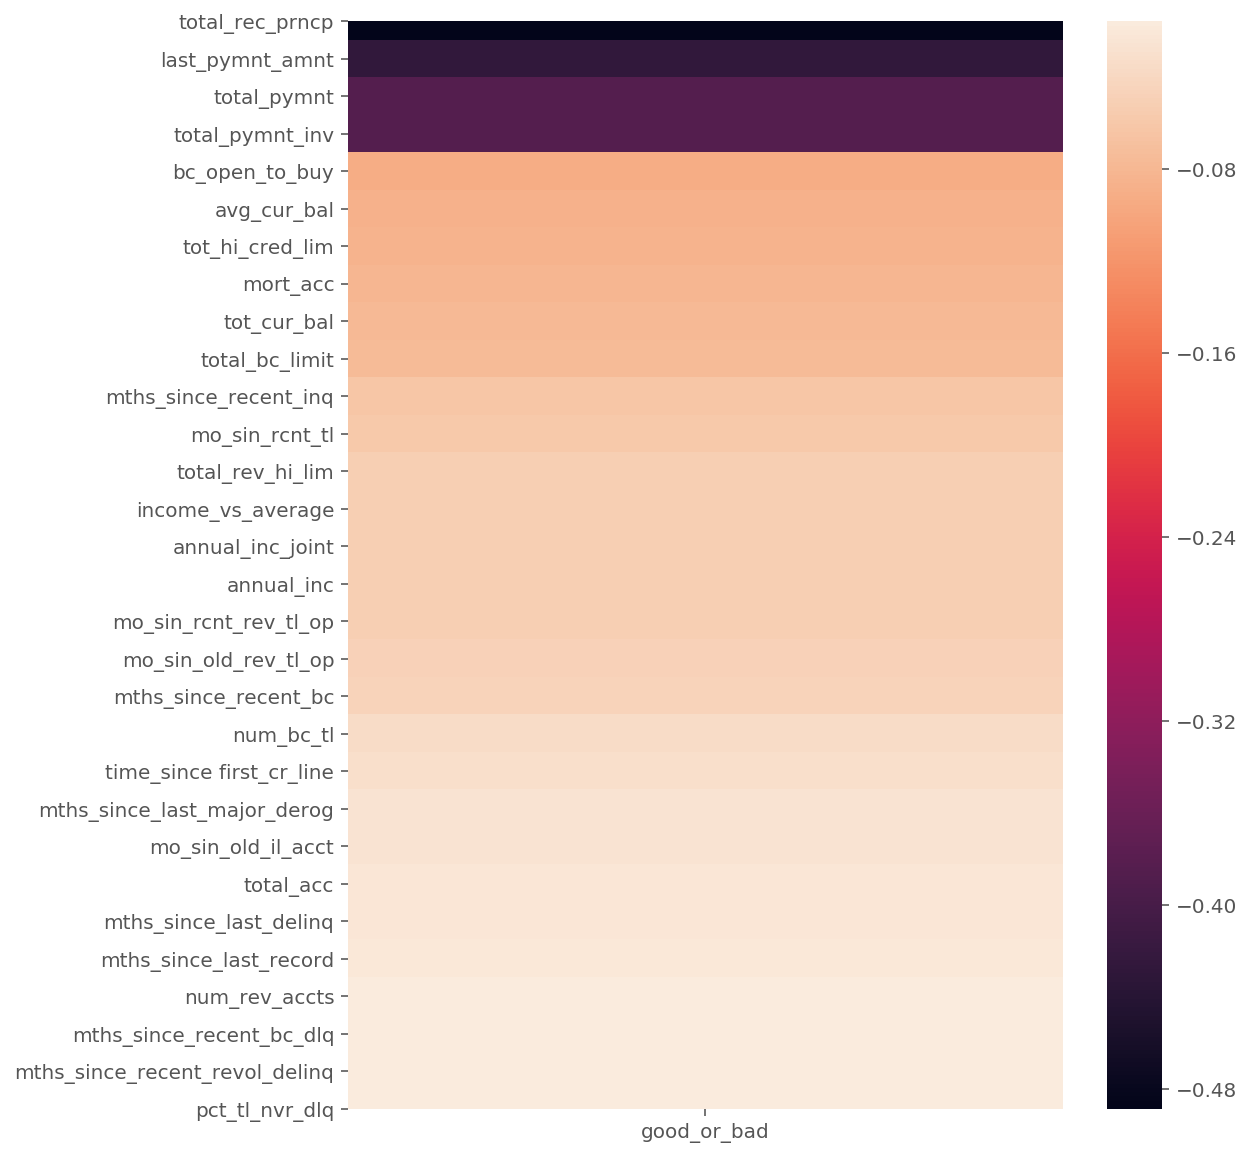

In [8]:
most_corr_negative = corr_with_loan_status.sort_values(ascending=True)[:30]
most_corr_df_neg = pd.DataFrame(most_corr_negative)
fig, ax = plt.subplots(figsize=(8, 10))
sns.heatmap(most_corr_df_neg)

As alluded to above some of the most negitively correlated variables such as total rec prncp and last payment amnt seemed to give too much away so were excluded. This was probably one of the most challenging parts of the project- deciding to leave out certain features knowing its going to seriously harm your results. 

In [9]:
#cramers_v is a correlation metric for categorical variables
#https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
#It is based on a nominal variation of Pearson’s Chi-Square Test


def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


p = []

categorical_cols = merged_df.select_dtypes(include='object')

for column in list(categorical_cols):
    p.append((column, cramers_v(merged_df[column], merged_df['good_or_bad'])))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


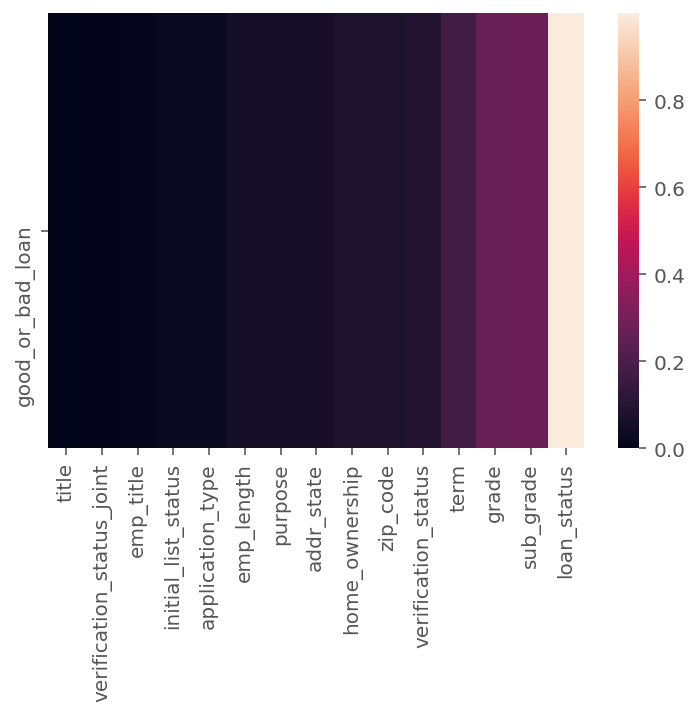

In [11]:
categorical_cramers_df = pd.DataFrame(p, columns=['names', 'correlation'])
categorical_cramers_df.dropna(inplace=True)
categorical_cramers_df.sort_values(by='correlation', inplace=True)
sns.heatmap([categorical_cramers_df.correlation.values],
            xticklabels=list(categorical_cramers_df.names),
            yticklabels=['good_or_bad_loan'])

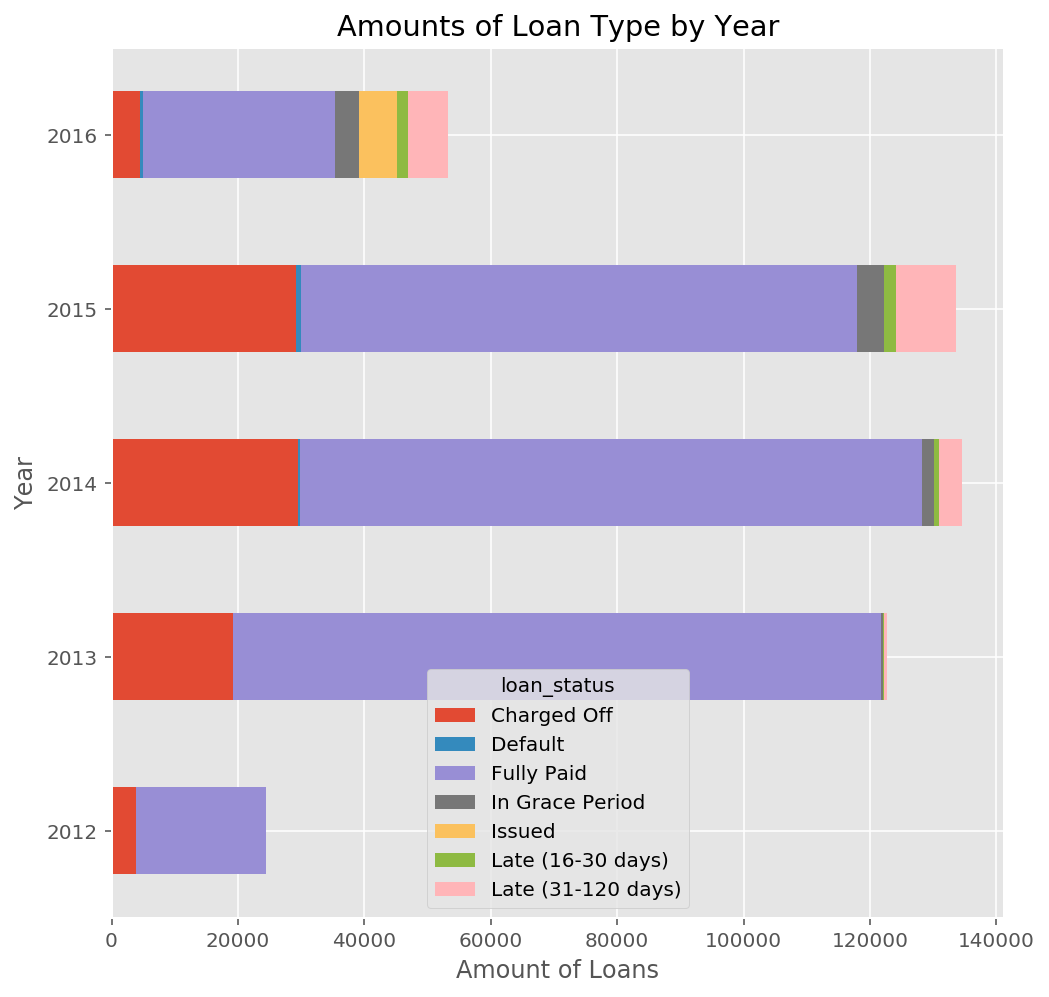

In [12]:
merged_df.groupby(['loan_status'
                   ])['Year'].value_counts().unstack(0).plot.barh(width=0.5,
                                                                  stacked=True,
                                                                  figsize=(8,
                                                                           8))
plt.ylabel('Year')
plt.xlabel('Amount of Loans')
plt.title('Amounts of Loan Type by Year')

In the above graph we can see that the data is imbalanced towards loans that have already been paid with charged off being the second most common loan type. It also seems as though this pattern is quite consistent throughout the years.

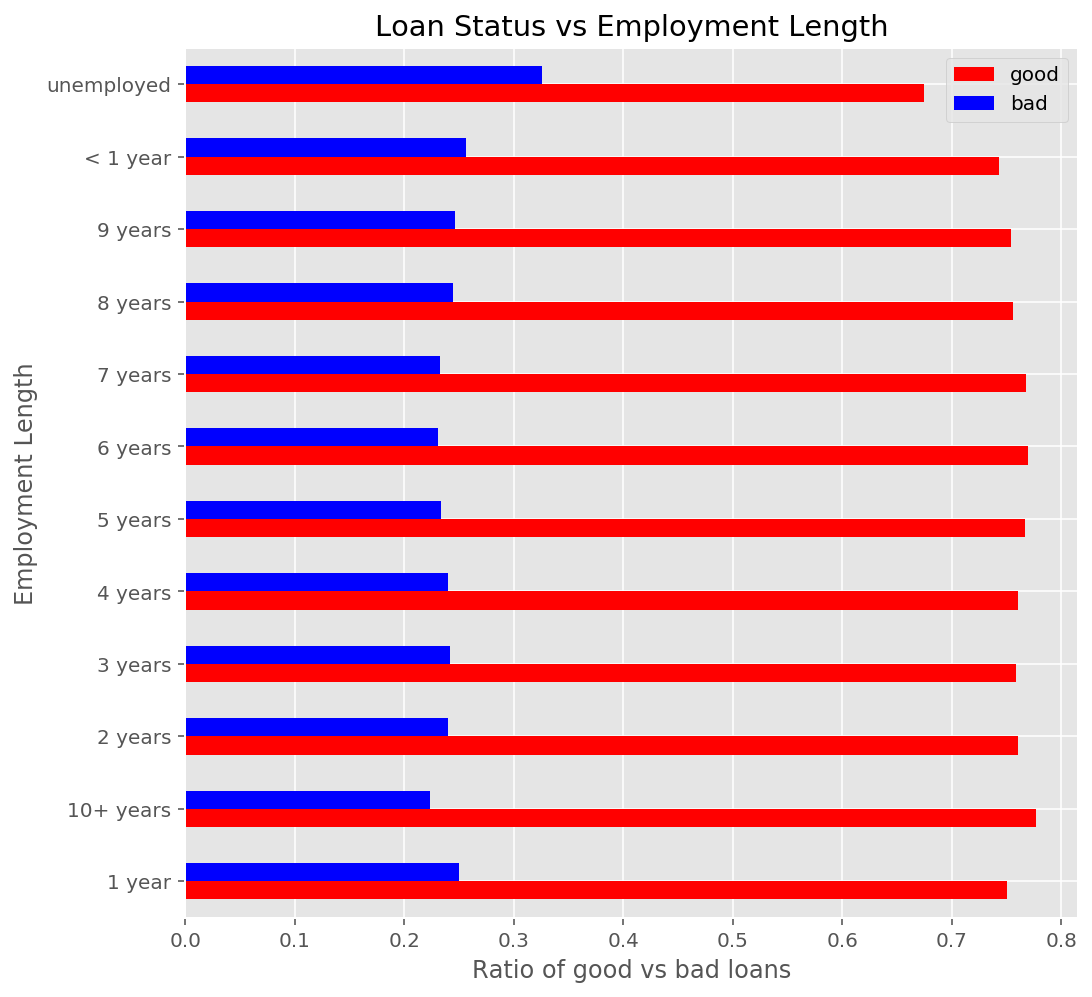

In [28]:
merged_df.groupby('emp_length')['good_or_bad'].value_counts(
    normalize=True).unstack().plot.barh(stacked=False,
                                        color=['red', 'blue'],
                                        figsize=(8, 8))
plt.xlabel('Ratio of good vs bad loans')
plt.ylabel('Employment Length')
plt.title('Loan Status vs Employment Length')
plt.legend(labels=['good', 'bad'], loc='upper right')

Here we can see that it is most common for someone who is unemployed or who has worked for a shorter amount of time to default on their loan.

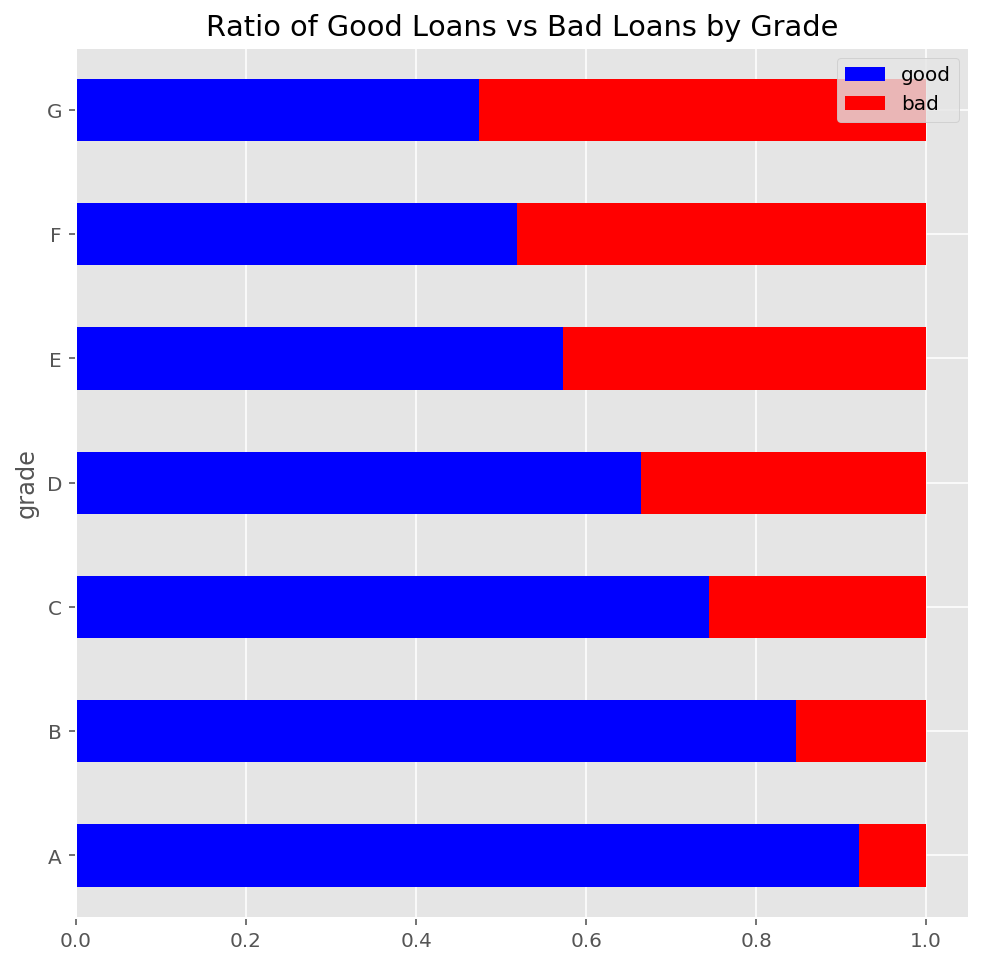

In [29]:
merged_df.groupby('grade')['good_or_bad'].value_counts(
    normalize=True).unstack().plot.barh(stacked=True,
                                        color=['blue', 'red'],
                                        figsize=(8, 8))
plt.title('Ratio of Good Loans vs Bad Loans by Grade')
plt.legend(labels=['good', 'bad'], loc='upper right')

because we can make more money on higher risk loans it makes sense to focus on the lower grades of loans vs A or B, therefore I am going to remove A and B grade loans from my model so I can train models on the data without it being too computationally expensive.

In [30]:
#finding the variables most correlated with loan outcome and making a list to use for creating some histograms
#finding non categorical columns
num_cols = [
    col for col in merged_df.columns if type(merged_df.loc[0, col]) != str
]
#finding the columns most correlated with outcome
most_corr_cont = merged_df[num_cols].corr()['good_or_bad'].abs().sort_values(
    ascending=False)[:17]
most_corr_cont_list = list(most_corr_cont.index)
#removing columns that are unusable
most_corr_cont_list.remove('good_or_bad')
most_corr_cont_list.remove('recoveries')
drop_cols = [
    'emp_title', 'total_rec_prncp', 'out_prncp_inv', 'total_pymnt_inv',
    'funded_amnt_inv', 'last_pymnt_d', 'out_prncp', 'total_pymnt',
    'total_rec_int', 'last_pymnt_amnt', 'id', 'member_id', 'year_issued',
    'collection_recovery_fee'
]
#creating a list of usable columns
used_cols = [col for col in most_corr_cont_list if col not in drop_cols]

In the below histograms we can see the variables most correlated with good or bad loans. This may be slightly worrying as none of them show much seperation between histograms.

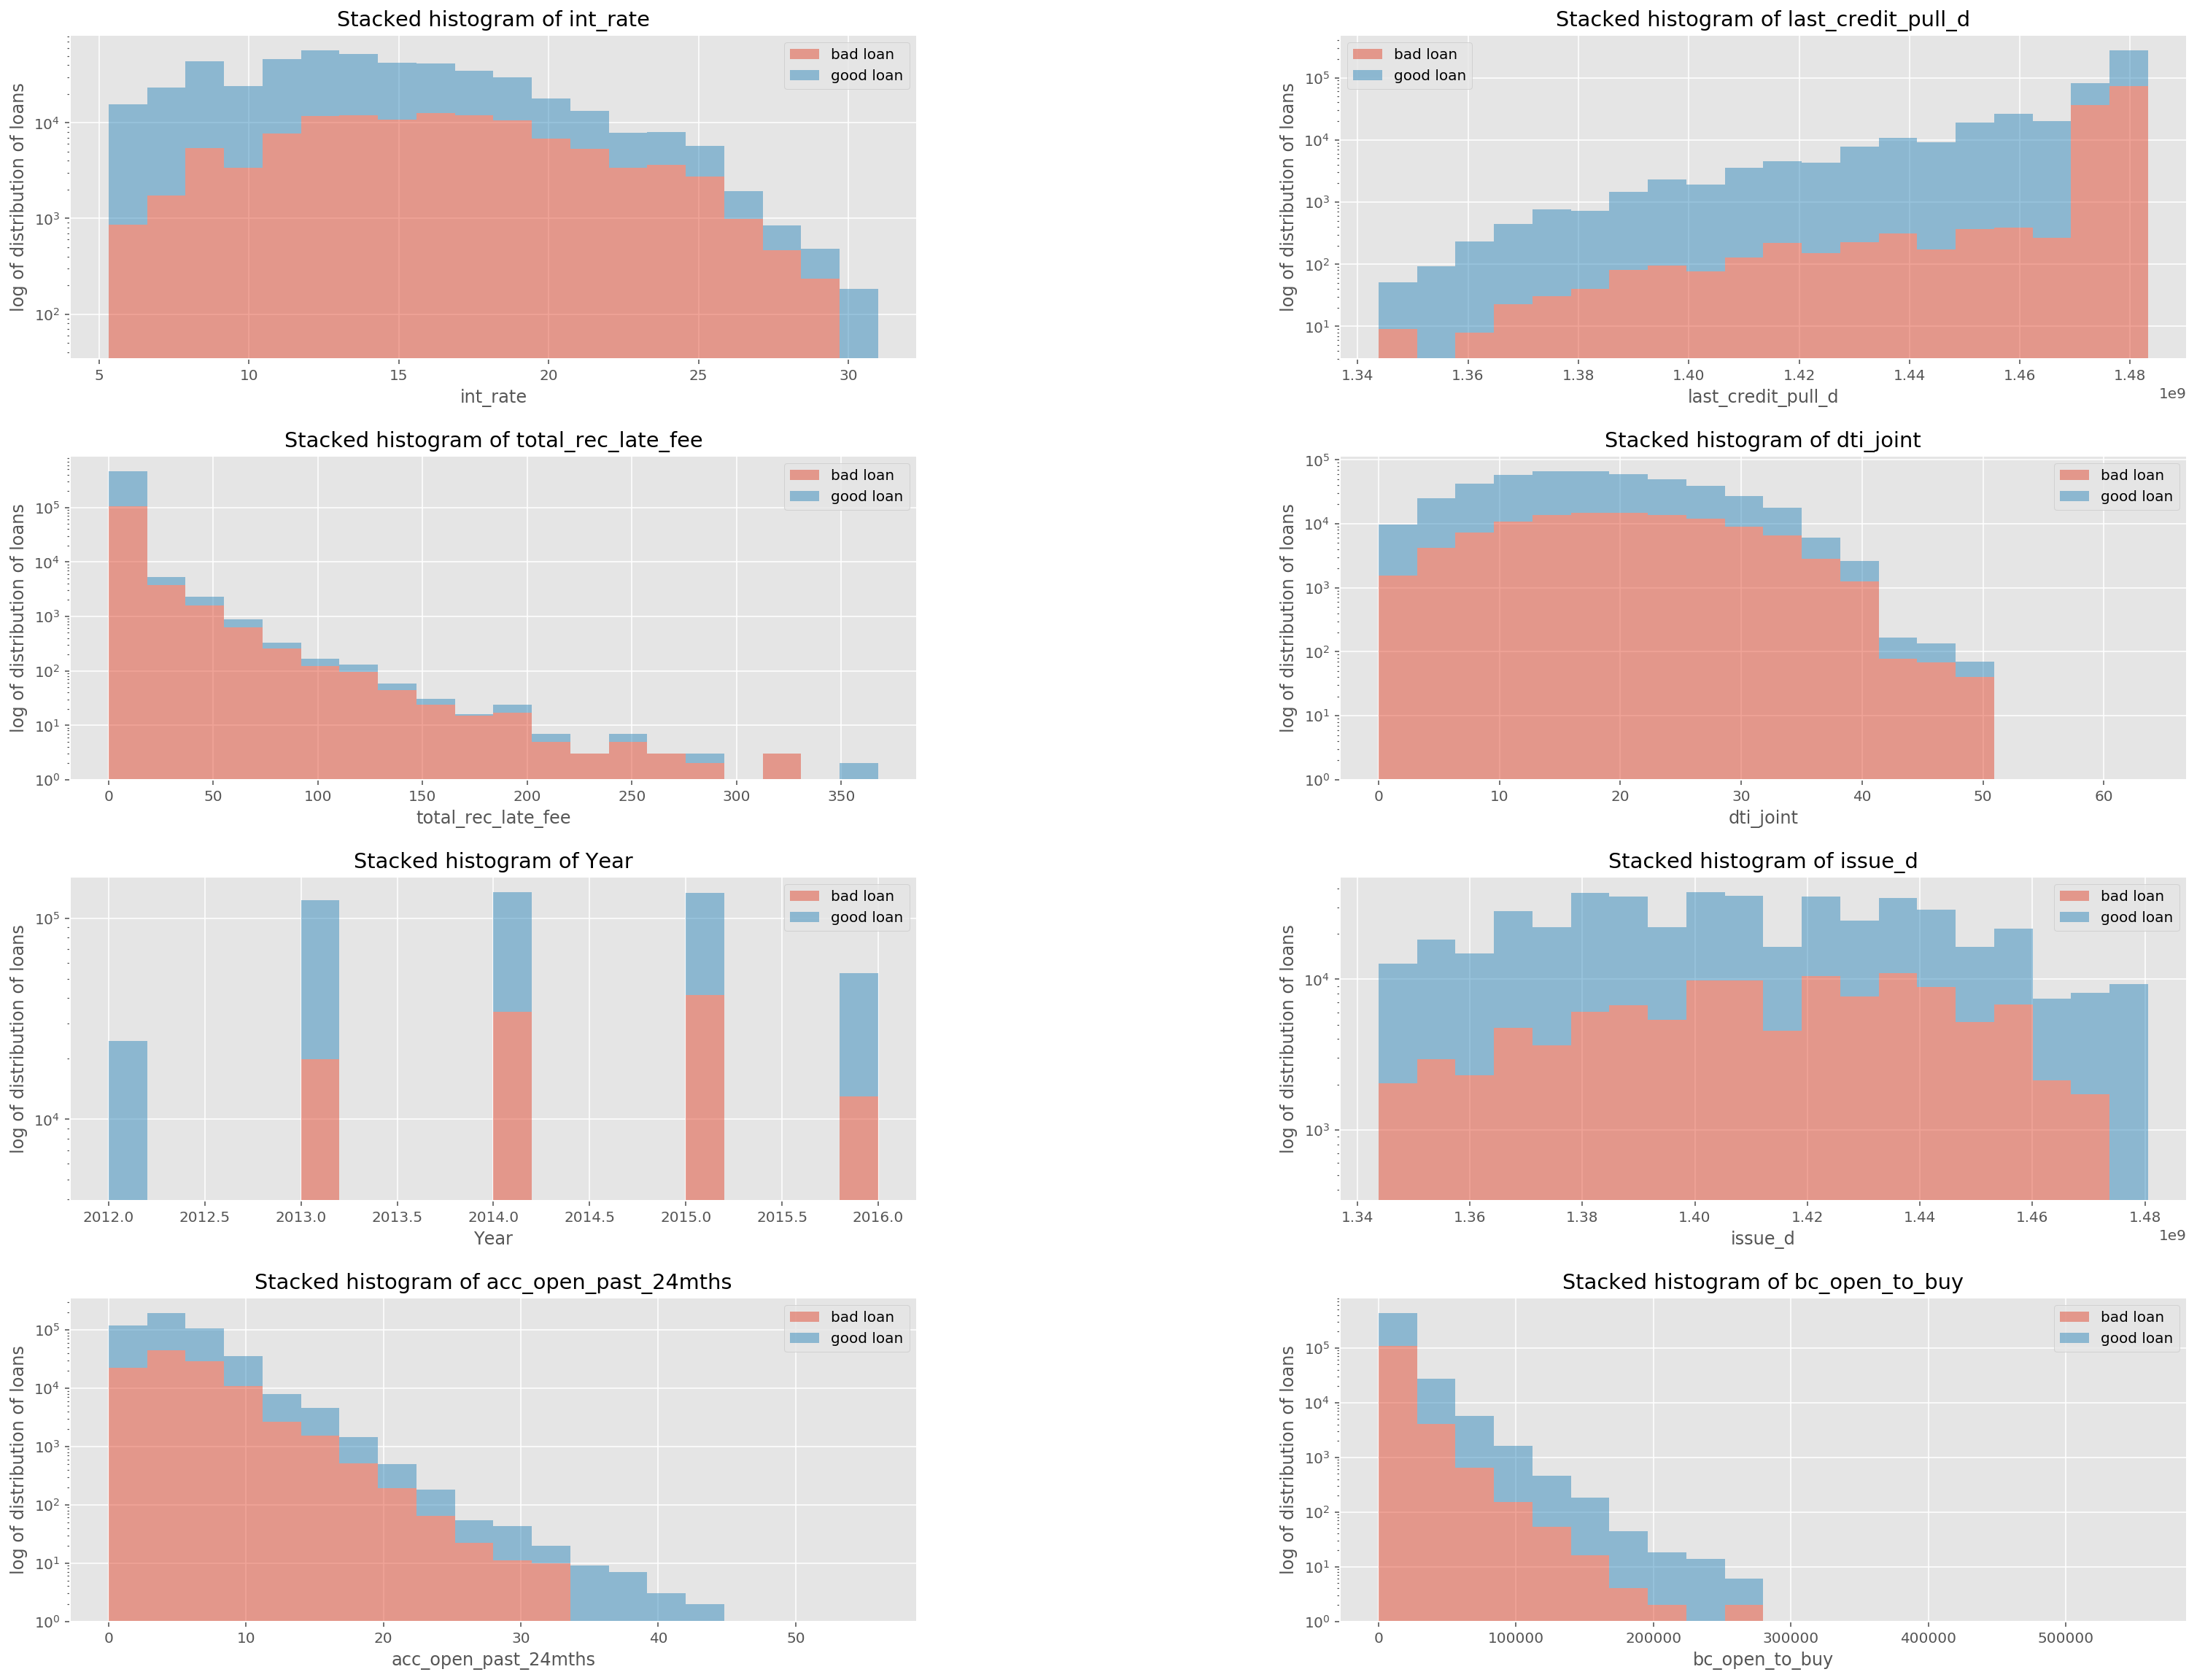

In [31]:
fig, ax = plt.subplots(4, 2, figsize=(26, 20))
fig.subplots_adjust(hspace=.3, wspace=0.5)
ax = ax.ravel()
for ind, column in enumerate(used_cols):
    ax[ind].hist([
        merged_df[merged_df.good_or_bad == 1][column],
        merged_df[merged_df.good_or_bad == 0][column]
    ],
                 bins=20,
                 stacked=True,
                 alpha=0.5,
                 label=['bad loan', 'good loan'],
                 log=True)
    ax[ind].legend(prop={'size': 10})

    ax[ind].set_title('Stacked histogram of {}'.format(column))
    ax[ind].set_xlabel(column)
    ax[ind].set_ylabel('log of distribution of loans')

In [32]:
temp_df = pd.read_csv('temp_df.csv')

The below scatter graphs highlight that loans going bad were on the surface not really that correlated with how much you earn. This was quite suprising to me as I thought that those with lower paying jobs would have a much higher chance of not being able to pay their loan back.

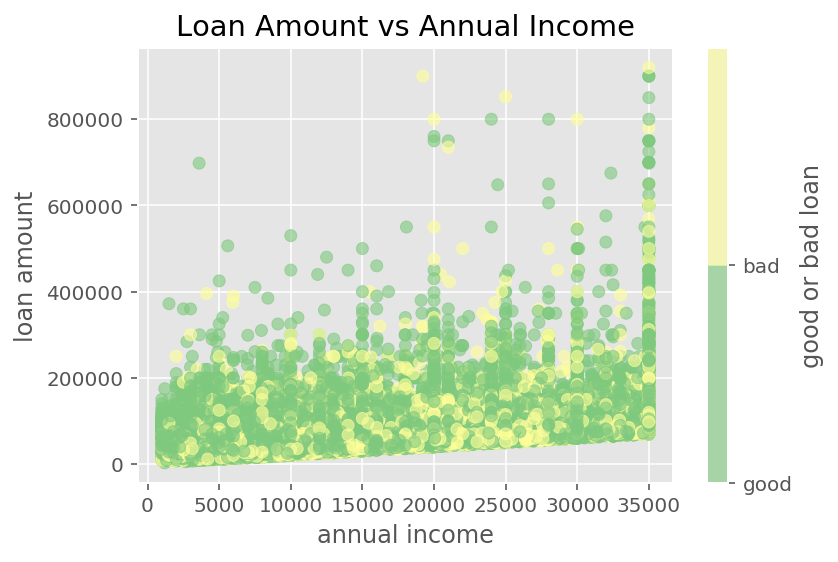

In [33]:
cmap1 = plt.cm.Accent(0)
cmap2 = plt.cm.Accent(3)
colors = [cmap1, cmap2]
plt.scatter(x=temp_df.loan_amnt,
            y=temp_df.annual_inc,
            c=temp_df.good_or_bad,
            alpha=0.6,
            cmap=ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0, max(temp_df.good_or_bad),
                max(temp_df.good_or_bad) / float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(['good', 'bad'])
cb.set_label('good or bad loan')
plt.title('Loan Amount vs Annual Income')
plt.xlabel('annual income')
plt.ylabel('loan amount')

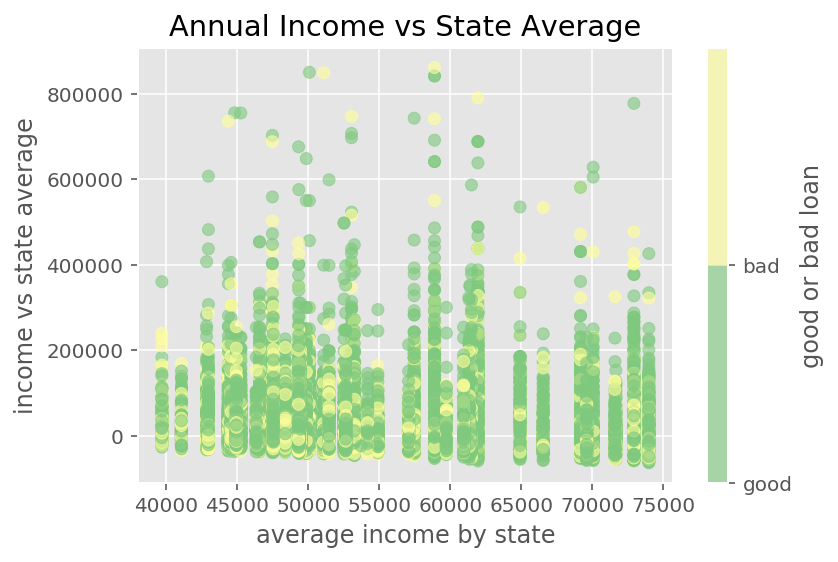

In [34]:
cmap1 = plt.cm.Accent(0)
cmap2 = plt.cm.Accent(3)
colors = [cmap1, cmap2]
plt.scatter(temp_df.average_income_state,
            temp_df.income_vs_average,
            c=temp_df.good_or_bad,
            alpha=0.6,
            cmap=ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0, max(temp_df.good_or_bad),
                max(temp_df.good_or_bad) / float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(['good', 'bad'])
cb.set_label('good or bad loan')
plt.title('Annual Income vs State Average')
plt.xlabel('average income by state')
plt.ylabel('income vs state average')

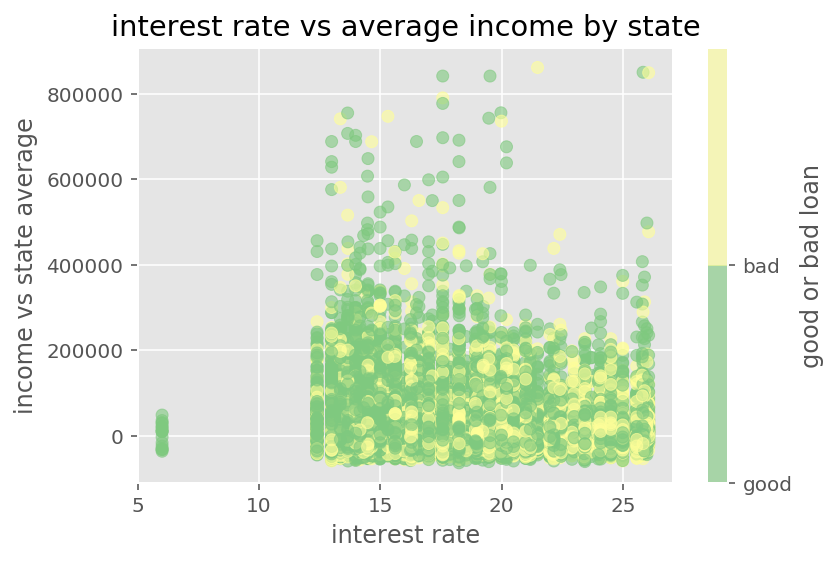

In [35]:
colors = [cmap1, cmap2]
plt.scatter(temp_df.int_rate,
            temp_df.income_vs_average,
            c=temp_df.good_or_bad,
            alpha=0.6,
            cmap=ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0, max(temp_df.good_or_bad),
                max(temp_df.good_or_bad) / float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(['good', 'bad'])
cb.set_label('good or bad loan')
plt.title('interest rate vs average income by state')
plt.xlabel('interest rate')
plt.ylabel('income vs state average')